In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [22]:
OUT_DIM=2

In [3]:
torch.cuda.set_device(1)

In [4]:
path = Path("./activations")

In [5]:
img_files = get_files(path/"img"); img_files

(#1278) [Path('activations/img/val/FirstPage/qji44a00.pt'),Path('activations/img/val/FirstPage/sdm51f00.pt'),Path('activations/img/val/FirstPage/tji44a00.pt'),Path('activations/img/val/FirstPage/sia26d00.pt'),Path('activations/img/val/FirstPage/sks41a00.pt'),Path('activations/img/val/FirstPage/sfp41a00-page5_1.pt'),Path('activations/img/val/FirstPage/pzm00d00.pt'),Path('activations/img/val/FirstPage/thl51a00-page02_1.pt'),Path('activations/img/val/FirstPage/qit05f00-page2_20.pt'),Path('activations/img/val/FirstPage/qin54c00_1.pt')...]

In [6]:
text_files = get_files(path/"text"); text_files

(#1278) [Path('activations/text/val/FirstPage/sji44a00.npy'),Path('activations/text/val/FirstPage/rkc33a00-page02_1.npy'),Path('activations/text/val/FirstPage/qaw85f00.npy'),Path('activations/text/val/FirstPage/suh90a00.npy'),Path('activations/text/val/FirstPage/ran25f00.npy'),Path('activations/text/val/FirstPage/ply60e00.npy'),Path('activations/text/val/FirstPage/pkc56d00.npy'),Path('activations/text/val/FirstPage/rzo50e00.npy'),Path('activations/text/val/FirstPage/qxf80f00-page01_1.npy'),Path('activations/text/val/FirstPage/pvx38c00-page06_10.npy')...]

In [7]:
len(img_files), len(text_files)

(1278, 1278)

In [8]:
train_csv = pd.read_csv("./data/train_fusion.csv")
val_csv = pd.read_csv("./data/val_fusion.csv")
test_csv = pd.read_csv("./data/test_fusion.csv")

In [9]:
train_csv["is_valid"] = False
val_csv["is_valid"] = True
data = pd.concat([train_csv, val_csv])

In [13]:
class GetActs(Transform):
    def encodes(self, x):    
        embs = []
        text_file = Path(x["activation_path"] + ".npy")
        img_file = Path(text_file.as_posix().replace("text", "img").replace("npy", "pt"))
        if img_file.exists(): 
#          print('found')
            img_emb = torch.load(img_file)
        else:
            print('cannot found')
            print(img_file)
            img_emb = torch.zeros([4096])
        text_emb = tensor(np.load(text_file))
        return (img_emb, text_emb)

In [14]:
# class GetActs(Transform):
#     def encodes(self, x):        
#         img_file = text_file = None
        
#         if x["has_text"]:
#             text_file = Path(x["activation_path"] + ".npy")
#             if x["has_image"]:
#                 img_file = Path(text_file.as_posix().replace("text", "img").replace("npy", "pt"))
#         else:
#             img_file = Path(x["activation_path"] + ".pt")
        
#         if img_file is None:
#             img_act = torch.zeros((4096))
#         else:
#             img_act = torch.load(img_file)
                            
#         if text_file is None:
#             text_act = torch.zeros((3840))
#             text_none = True
#         else:
#             text_act = tensor(np.load(text_file))
        
#         img_none = img_file == None
#         text_none = text_file == None
                            
#         return (img_act, text_act, img_none, text_none)

In [15]:
tfms = [[GetActs()], [ColReader("class"), Categorize()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders()

In [16]:
dls.train_ds, dls.valid_ds

((#819) [((TensorImage([0.5401, 1.4210, 1.5567,  ..., 0.0664, 0.0852, 0.1008]), tensor([0.0382, 0.0748, 0.0380,  ..., 0.0000, 0.0852, 0.0000])), TensorCategory(0)),((TensorImage([0.3286, 0.6557, 1.1641,  ..., 0.0486, 0.0315, 0.1749]), tensor([0.0206, 0.0280, 0.0178,  ..., 0.0000, 0.0852, 0.0000])), TensorCategory(1)),((TensorImage([0.7914, 1.7443, 2.2198,  ..., 0.0976, 0.0466, 0.0242]), tensor([0.0393, 0.0601, 0.0385,  ..., 0.0541, 0.0855, 0.1106])), TensorCategory(0)),((TensorImage([0.4776, 0.3866, 0.8470,  ..., 0.0112, 0.0985, 0.1097]), tensor([0.0320, 0.0779, 0.0311,  ..., 0.0000, 0.0852, 0.0000])), TensorCategory(0)),((TensorImage([1.0748, 1.4416, 0.6812,  ..., 0.1042, 0.0102, 0.3972]), tensor([0.0190, 0.0571, 0.0499,  ..., 0.0000, 0.0852, 0.0000])), TensorCategory(1)),((TensorImage([1.6522, 2.1665, 0.8193,  ..., 0.0739, 0.0450, 0.4636]), tensor([0.0621, 0.0297, 0.0177,  ..., 0.0000, 0.0852, 0.0000])), TensorCategory(0)),((TensorImage([0.3560, 0.5303, 0.9616,  ..., 0.0529, 0.1349, 

In [17]:
torch.save(dls, "./data/fusion_dl_tobacco.pth")

In [18]:
dls = torch.load("./data/fusion_dl_tobacco.pth")

In [19]:
class ImgTextFusion(Module):
    def __init__(self, head, img_emb_dim=4096, text_emb_dim=3840):
        self.head = head.cuda()
    
    def forward(self, x):
        img_act, text_act = x
        return self.head(torch.cat([img_act, text_act], axis=-1))

In [20]:
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(c)
    return nn.Sequential(*layers)

In [25]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [26]:
fscore = F1Score(average='macro')

In [31]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [32]:
model = ImgTextFusion(head)

In [33]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [34]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128_moreEpochs_tobacco'),
                                       ShowGraphCallback()])

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=3.630780702224001e-05)

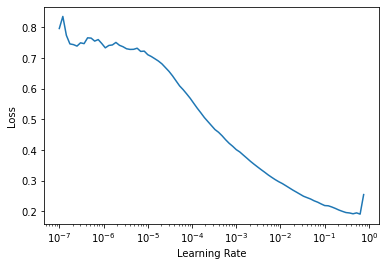

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.181887,0.574807,0.755000,0.753217,00:01
1,0.105349,0.543806,0.785000,0.784866,00:01
2,0.073627,0.773029,0.730000,0.725359,00:01
3,0.062088,0.695150,0.755000,0.754847,00:01
4,0.050244,0.700677,0.700000,0.698068,00:01
5,0.050136,0.982550,0.765000,0.764994,00:01
6,0.039359,0.785321,0.755000,0.754700,00:01
7,0.038128,0.903872,0.760000,0.759784,00:01
8,0.040919,1.046441,0.740000,0.739766,00:01
9,0.039659,0.813097,0.760000,0.759976,00:01


Better model found at epoch 0 with f1_score value: 0.7532169927727833.


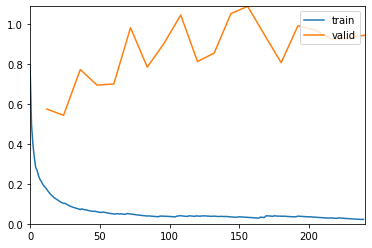

Better model found at epoch 1 with f1_score value: 0.784865540963102.


In [36]:
learn.fit_one_cycle(20, lr_max=1e-2)

In [37]:
learn.load("best_fusion_128_moreEpochs_tobacco")

In [42]:
preds, targets = learn.get_preds(ds_idx=0)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.9506    0.9737    0.9620       494
    NextPage     0.9585    0.9231    0.9404       325

    accuracy                         0.9536       819
   macro avg     0.9545    0.9484    0.9512       819
weighted avg     0.9537    0.9536    0.9534       819



In [38]:
preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.7168    0.8804    0.7902        92
    NextPage     0.8736    0.7037    0.7795       108

    accuracy                         0.7850       200
   macro avg     0.7952    0.7921    0.7849       200
weighted avg     0.8015    0.7850    0.7844       200



In [40]:
test_dl = dls.test_dl(test_csv, with_labels=True)

In [41]:
preds, targets = learn.get_preds(dl=test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.8430    0.9667    0.9006       150
    NextPage     0.9425    0.7523    0.8367       109

    accuracy                         0.8764       259
   macro avg     0.8928    0.8595    0.8687       259
weighted avg     0.8849    0.8764    0.8737       259

